# Image segmentation using K-means Clustering 
In this notebook here it demonstrates the process of applying segmentation to an image using K-means clustering.
## Image segmentation
Image segmentation is the process of partitioning a digital image into multiple segments (sets of pixels, also known as image objects).The goal of segmentation is to simplify and/or change the representation of an image into something that is more meaningful and easier to analyze.
## K-means Clustering
K-means clustering is a method which clustering data points or vectors with respect to nearest mean points (Here K is numbers of mean or cluster).This results in a partitioning of the data points or vectors space into <a href="https://en.wikipedia.org/wiki/Voronoi_diagram">Voronoi cells</a>.

### Algorithm in pseudocode:
- Initialize k means with random values

- For a given number of iterations:
    - Iterate through items:
        - Find the mean closest to the item
        - Assign item to mean
        - Update mean

In [1]:
# Loading required libraries
import numpy as np 
import matplotlib.pyplot as plt 
import cv2 

from __future__ import print_function
import cv2 as cv
import argparse
import random as rng

import os
from rembg import remove, new_session
from PIL import Image
from tqdm import tqdm
import typing as typ

## cv2.imread
Use the function cv2.imread() to read an image. <br>

argument 1 : The image should be in the working directory or a full path of image should be given.<br>
argument 2 : Is a flag which specifies the way image should be read.
    - cv2.IMREAD_COLOR : Loads a color image. Any transparency of image will be neglected. It is the default flag.
    - cv2.IMREAD_GRAYSCALE : Loads image in grayscale mode
    - cv2.IMREAD_UNCHANGED : Loads image as such including alpha channel
<em> Note: Instead of these three flags, you can simply pass integers 1, 0 or -1 respectivel</em>

In [2]:
image = cv2.imread("../data/raw/baby.jpg")

## cv2.cvtColor
Used to convert an image from one color space to another. There are more than 150 color-space conversion methods available in OpenCV<br>
#### Parameters:
- src   : It is the image whose color space is to be changed.
- code  : It is the color space conversion code.
- dst   : It is the output image of the same size and depth as src image. It is an optional parameter.
- dstCn : It is the number of channels in the destination image. If the parameter is 0 then the number of the channels is derived automatically from src and code. It is an optional parameter.

#### Return Value:
- It returns an image

In [3]:
# Change color to RGB (from BGR) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

In [ ]:
plt.imshow(image)

In [ ]:
MODELS: typ.List[str] = [
    "u2net",
    "u2netp",
    "u2net_human_seg",
    "silueta",
    "u2net_cloth_seg",
    "isnet-general-use",
    "isnet-anime",
    "sam_prompt"
    ]

print(MODELS)

In [ ]:
# https://sarit-r.medium.com/remove-background-with-a-i-31d73e2aaacd
def main() -> None:
    """Run main function."""
    samples = [
        ('baby', "../data/raw/baby.jpg")        
    ]
    for model_name in tqdm(MODELS):
        for title, input_path in samples:
            input = Image.open(input_path)
            session = new_session(model_name)
            
            output = remove(input, session=session,
                                post_process_mask=False,
                                alpha_matting=True, 
                                alpha_matting_foreground_threshold=350,
                                alpha_matting_background_threshold=20, 
                                alpha_matting_erode_size=19,
                                background_color=(255, 255, 255))
            output.save(f"el/{model_name}_{title}.png")


if __name__ == "__main__":
    main()

In [4]:
# https://www.horilla.com/blogs/how-to-remove-the-background-of-image-using-rembg-in-python/

def remove_background_advanced(input_path, output_path, alpha_matte=False, background_color=(255, 255, 255)):
    
    model_name = "isnet-general-use"
    #model_name = "sam_prompt"
    
    session = new_session(model_name)

    with open(input_path, "rb") as input_file, open(output_path, "wb") as output_file:
        input_data = input_file.read()
        
        # Use advanced options
        output_data = remove(input_data, alpha_matte = alpha_matte, background_color = background_color, session = session)
        
        output_file.write(output_data)

# Specify input and output paths
#input_image_path = image
input_image_path           = "../data/raw/baby.jpg"
output_image_path_advanced = "output_image_advanced.png"

# Remove background with advanced options
remove_background_advanced(input_image_path, output_image_path_advanced, alpha_matte=True, background_color=(0, 0, 0))

# Display the results
removed_background_image_advanced = Image.open(output_image_path_advanced)
removed_background_image_advanced.show(title = "Image with Removed Background")



## cv2.kmeans
#### Parameters:
- samples : It should be of np.float32 data type, and each feature should be put in a single column.<br>
- nclusters(K) : Number of clusters required at end<br>
- criteria : It is the iteration termination criteria. When this criteria is satisfied, algorithm iteration stops. Actually, it should be a tuple of 3 parameters. They are `( type, max_iter, epsilon )`:<br>
  - type of termination criteria. It has 3 flags as below:
    - cv.TERM_CRITERIA_EPS - stop the algorithm iteration if specified accuracy, epsilon, is reached.
    - cv.TERM_CRITERIA_MAX_ITER - stop the algorithm after the specified number of iterations, max_iter.
   - cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER - stop the iteration when any of the above condition is met.
   - max_iter - An integer specifying maximum number of iterations.<br>
epsilon - Required accuracy<br>
- attempts : Flag to specify the number of times the algorithm is executed using different initial labellings. The algorithm returns the labels that yield the best compactness. This compactness is returned as output.<br>
- flags : This flag is used to specify how initial centers are taken. Normally two flags are used for this : cv.KMEANS_PP_CENTERS and cv.KMEANS_RANDOM_CENTERS.

#### Return Value:
- compactness : It is the sum of squared distance from each point to their corresponding centers.
- labels : This is the label array (same as 'code' in previous article) where each element marked '0', '1'.....
- centers : This is array of centers of clusters.

In [5]:
image2 = cv2.imread("output_image_advanced.png")

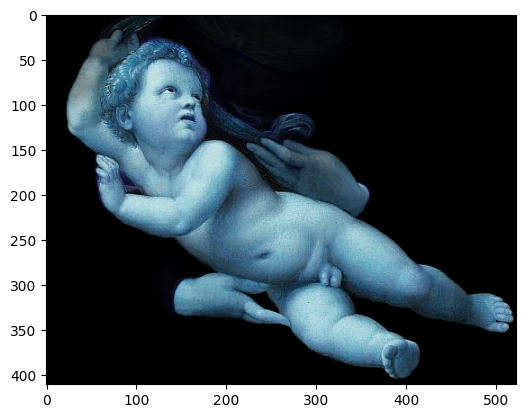

In [6]:
plt.imshow(image2)

In [7]:
# Reshaping the image into a 2D array of pixels and 3 color values (RGB) 
pixel_vals = image2.reshape((-1,3)) # numpy reshape operation -1 unspecified 

# Convert to float type only for supporting cv2.kmean
pixel_vals = np.float32(pixel_vals)

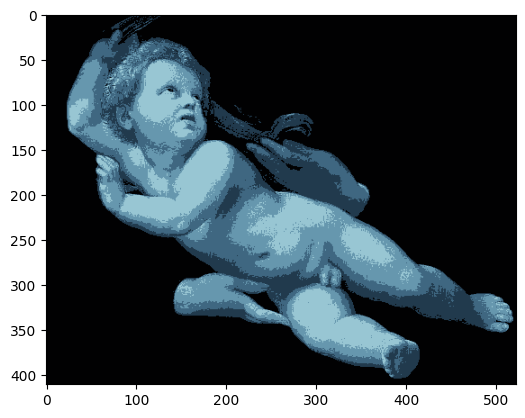

In [9]:
#criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85) 
  
# Choosing number of cluster
k = 5

retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS) 
  
# convert data into 8-bit values 
centers = np.uint8(centers) 

segmented_data = centers[labels.flatten()] # Mapping labels to center points( RGB Value)

# reshape data into the original image dimensions 
segmented_image = segmented_data.reshape((image2.shape)) 
  
plt.imshow(segmented_image)

In [10]:
# Write Images to File
cv2.imwrite('kmeans_image.jpg', segmented_image)

True

In [11]:
rng.seed(12345)

change the background from white to black, since that will help later to extract better results during the use of Distance Transform

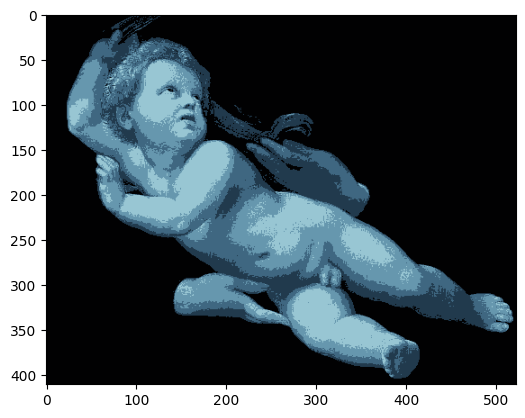

In [12]:
#image = cv2.imread("../data/interim/no_background/output_0_Edinburgh_Nat_Gallery.jpg",1)

src = segmented_image
src[np.all(src == 255, axis=2)] = 0

# Show output image
plt.imshow(src, cmap='gray')

Afterwards we will sharpen our image in order to acute the edges of the foreground objects. We will apply a laplacian filter with a quite strong filter (an approximation of second derivative):

In [13]:
# Create a kernel that we will use to sharpen our image
# an approximation of second derivative, a quite strong kernel
kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)

In [14]:
# do the laplacian filtering as it is well, we need to convert everything in something more deeper then CV_8U
# because the kernel has some negative values, and we can expect in general to have a Laplacian image with negative values
# BUT a 8bits unsigned int (the one we are working with) can contain values from 0 to 255 so the possible negative number will be truncated
imgLaplacian = cv2.filter2D(src, cv2.CV_32F, kernel)
sharp = np.float32(src)
imgResult = sharp - imgLaplacian

In [15]:
# convert back to 8bits gray scale
imgResult = np.clip(imgResult, 0, 255)
imgResult = imgResult.astype('uint8')
imgLaplacian = np.clip(imgLaplacian, 0, 255)
imgLaplacian = np.uint8(imgLaplacian)

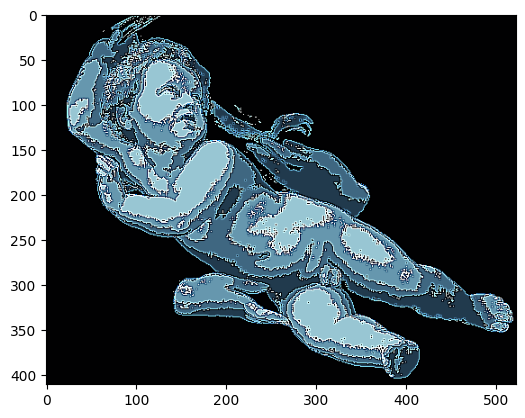

In [16]:
plt.imshow(imgResult, cmap='gray')

Now we transform our new sharpened source image to a grayscale and a binary one, respectively

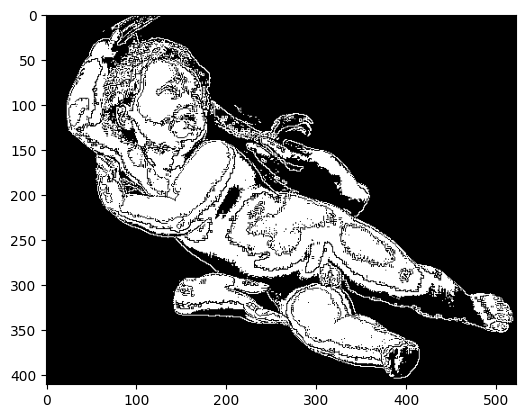

In [20]:
# Create binary image from source image
bw = cv2.cvtColor(imgResult, cv2.COLOR_BGR2GRAY)
_, bw = cv2.threshold(bw, 40, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(bw, cmap='gray')

We are ready now to apply the Distance Transform on the binary image. Moreover, we normalize the output image in order to be able visualize and threshold the result:

In [21]:
# Write Images to File
cv2.imwrite('baby_bw.jpg', bw)

True

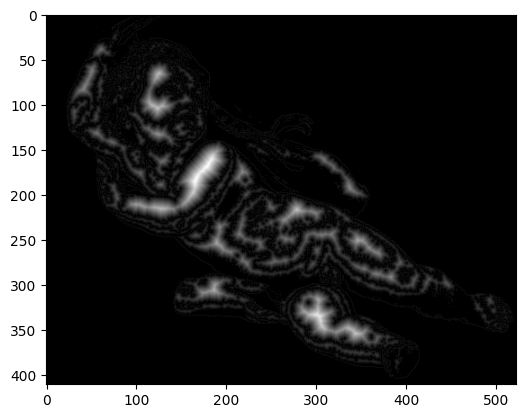

In [26]:
# Perform the distance transform algorithm
dist = cv2.distanceTransform(bw, cv2.DIST_L2, 3)

# Normalize the distance image for range = {0.0, 1.0} so we can visualize and threshold it
cv2.normalize(dist, dist, 0, 1, cv2.NORM_MINMAX)
plt.imshow(dist, cmap='gray')
plt.show()

We threshold the dist image and then perform some morphology operation (i.e. dilation) in order to extract the peaks from the above image:

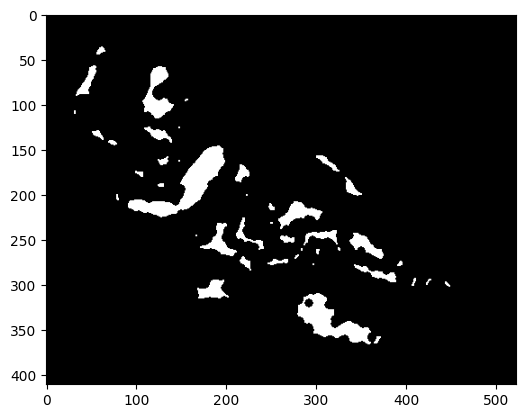

In [27]:
# Threshold to obtain the peaks
# This will be the markers for the foreground objects
_, dist = cv2.threshold(dist, 0.3, 1, cv2.THRESH_BINARY)

# Dilate a bit the dist image
kernel1 = np.ones((2,2), dtype=np.uint8)
dist = cv2.dilate(dist, kernel1)
plt.imshow(dist, cmap='gray')
plt.show()

In [ ]:
image = cv2.imread("output_image_advanced.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 100, 220, apertureSize=3)

contours,hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

cv2.drawContours(image, contours, -1, (0,255,0), 3)

plt.imshow(image)

From each blob then we create a seed/marker for the watershed algorithm with the help of the cv::findContours function:

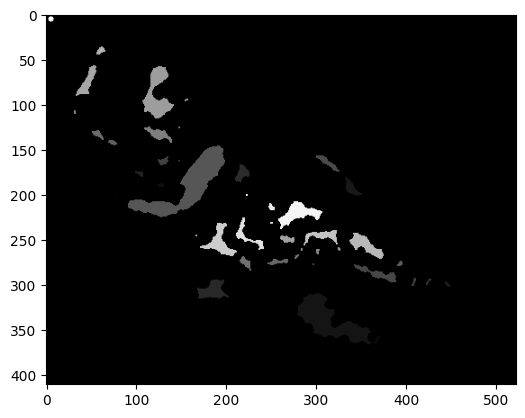

In [28]:
# Create the CV_8U version of the distance image
# It is needed for findContours()
dist_8u = dist.astype('uint8')

# Find total markers
contours, _ = cv2.findContours(dist_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create the marker image for the watershed algorithm
markers = np.zeros(dist.shape, dtype=np.int32)

# Draw the foreground markers
for i in range(len(contours)):
    cv2.drawContours(markers, contours, i, (i+1), -1)

# Draw the background marker
cv2.circle(markers, (5,5), 3, (255,255,255), -1)
markers_8u = (markers * 10).astype('uint8')
plt.imshow(markers_8u,cmap='gray')

In [29]:

# Perform the watershed algorithm
cv2.watershed(imgResult, markers)

#mark = np.zeros(markers.shape, dtype=np.uint8)

mark = markers.astype('uint8')
mark = cv2.bitwise_not(mark)

# uncomment this if you want to see how the mark
# image looks like at that point
#cv.imshow('Markers_v2', mark)
# Generate random colors

colors = []

for contour in contours:
    colors.append((rng.randint(0,256), rng.randint(0,256), rng.randint(0,256)))

# Create the result image
dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)

# Fill labeled objects with random colors
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        index = markers[i,j]
        if index > 0 and index <= len(contours):
            dst[i,j,:] = colors[index-1]

# Visualize the final image
cv.imshow('Final Result', dst)
cv.waitKey()

32

In [ ]:
# Import Libraries
import cv2, torch
import supervision as sv
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamAutomaticMaskGenerator, SamPredictor


In [ ]:
# Note that Segment anything requires that you download the checkpoint.  In my case I downloaded it to the same path as the image

# Replace the following with the actual paths and model type
model_type = "default" # default is the same as vit_h
checkpoint_path = "../data/sam/sam_vit_h_4b8939.pth" # you have to download this from the github 
image_path = "../data/raw/kmeans_image.jpg"

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
min_area = 40/100  # 0.1% of image area (figures should be larger than 04% of the image area)
max_area = 60/100 # 0.6% of image area (insects should be smaller than 0.6% of the image area)


In [ ]:
# Print Information for this run
print('Device in use =', DEVICE)

# Load the image
#image = cv2.imread(image_path)
image = cv2.imread("output_image_advanced.png")


In [ ]:

# Create the SAM model and mask generator
sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
mask_generator = SamAutomaticMaskGenerator(sam)

# Generate masks for the entire image
masks = mask_generator.generate(image)

# takes 7-8 minutes to run

In [ ]:

# Calculate the threshold for mask area (40% of the image size)
area_hi_thres = max_area * image.shape[0] * image.shape[1]
area_low_thres = min_area * image.shape[0] * image.shape[1]


In [ ]:

# Filter the masks based on their area
filtered_masks = [mask for mask in masks if area_low_thres < mask['area'] < area_hi_thres]

In [ ]:

# Use supervision package to anotate masks
#mask_annotator = sv.MaskAnnotator()
mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)

In [ ]:
detections = sv.Detections.from_sam(masks)

In [ ]:
annotated_image = mask_annotator.annotate(image, detections)

In [ ]:

# Write Images to File
cv2.imwrite('annotated_image.jpg', annotated_image)

# Print the count
print('Number of Objects', len(filtered_masks))

In [ ]:
mask_predictor = SamPredictor(sam)

image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
mask_predictor.set_image(image_rgb)

box = np.array([70, 247, 626, 926])
masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

In [ ]:
masks.shape

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [ ]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

https://stackoverflow.com/questions/76870102/how-to-save-segmented-images-or-masks-using-segment-anything-model-sam